In [24]:
import numpy as np
from numpy import random
import time
import pickle
import os
import pathlib
import inspect

from Data import data_generation
from OLS import ols_method
from DDR import ddr_method
from SPO_Plus import SPO_plus_method
from Performance import performance_evaluation
from Figure import regret_h2h
regret_h2h_fig = regret_h2h()

# Store results

In [25]:
def store_results(file_name, **kwargs):
    """
    存储变量名和值到字典，并保存为 pickle 文件。

    参数:
    - file_name (str): 要存储的 pickle 文件名
    - **kwargs: 需要存储的变量（自动识别变量名）

    返回:
    - result: 包含变量名和值的字典
    """
    result = {}
    frame = inspect.currentframe().f_back  # 获取上一层调用的栈帧
    # 遍历 kwargs 变量
    for key, value in kwargs.items():
        result[key] = value
    # 存储为 pickle 文件
    with open(file_name, "wb") as f:
        pickle.dump(result, f)

# Comparison

In [26]:
def calculate_comparison(file_name,perf_eva,c_item, c_base, c_oracle,ypio):
    if ypio == 0:
#     # compares results
        lbels, h2h, mci = perf_eva.cross_compare2(c_item, c_base, c_oracle)
        store_results(file_name,lbels=lbels,h2h=h2h,mci=mci)
        print("h2h = ",h2h)
    else:
        # compares results plus
        lbels, h2h, mci, pio = perf_eva.cross_compare2plus(c_item, c_base, c_oracle)
        store_results(file_name,lbels=lbels,h2h=h2h,mci=mci,pio=pio)
        print("h2h = ",h2h," pio = ",pio)
    # return lbels, h2h, mci

# Oracle

In [27]:
def implement_oracle(perf_eva,file_path,data, mis, thres, mu, lamb, ypio = 0):
    x_test, z_test_ori, z_test, x_train, z_train_ori, z_train, W_star = data
    y_test_opt = perf_eva.decision_finder(z_test_ori)
    c_oracle = np.mean(np.sum(np.minimum(z_test_ori,thres) * y_test_opt, axis = 1))
    store_results(file_path+"Oracle.pkl",W = W_star,W0=W_star,time=0,y_test=y_test_opt,cost=c_oracle)
    return c_oracle

# OLS

In [28]:
def implement_ols(perf_eva,file_path,data, mis, thres, mu, lamb, ypio = 0):
    x_test, z_test_ori, z_test, x_train, z_train_ori, z_train, W_star = data
    ## Solve and evaluate the OLS model
    ols_method_obj = ols_method()
    W_ols, w0_ols, t_ols, obj_ols = ols_method_obj.ols_solver(file_path,x_train, z_train)
    # print("W_ols = ",W_ols)
    z_test_ols, y_test_ols, c_test_ols = perf_eva.param_prediction_and_cost_estimation(x_test, W_ols, w0_ols, thres)
    c_ols_true =  np.sum(np.minimum(z_test_ori,thres) * y_test_ols, axis = 1)
    store_results(file_path+"OLS.pkl",W = W_ols,W0=w0_ols,time=t_ols,y_test=y_test_ols,cost=c_ols_true)

    return c_ols_true

# Lasso

In [29]:
def implement_lasso(perf_eva,file_path,data, mis, thres, mu, lamb, ypio = 0):
    x_test, z_test_ori, z_test, x_train, z_train_ori, z_train, W_star = data
    ols_method_obj = ols_method()
    W_lso, w0_lso, t_lso = ols_method_obj.lasso_solver(x_train, z_train)
    z_test_lso, y_test_lso, c_test_lso = perf_eva.param_prediction_and_cost_estimation(x_test, W_lso, w0_lso, thres)
    c_lso_true =  np.sum(np.minimum(z_test_ori,thres) * y_test_lso, axis = 1)
    store_results(file_path+"Lasso.pkl",W = W_lso,W0=w0_lso,time=t_lso,y_test=y_test_lso,cost=c_lso_true)

    return c_lso_true

# Ridge

In [30]:

def implement_ridge(perf_eva,file_path,data, mis, thres, mu, lamb, ypio = 0):
    x_test, z_test_ori, z_test, x_train, z_train_ori, z_train, W_star = data
    ols_method_obj = ols_method()
    W_rgi, w0_rgi, t_rgi = ols_method_obj.ridge_solver(x_train, z_train)
    z_test_rgi, y_test_rgi, c_test_rgi = perf_eva.param_prediction_and_cost_estimation(x_test, W_rgi, w0_rgi, thres)
    c_rgi_true =  np.sum(np.minimum(z_test_ori,thres) * y_test_rgi, axis = 1)
    store_results(file_path+"Ridge.pkl",W = W_rgi,W0=w0_rgi,time=t_rgi,y_test=y_test_rgi,cost=c_rgi_true)

    return c_rgi_true


# DDR

In [31]:
def implement_ddr(perf_eva,file_path,data, mis, thres, mu, lamb, ypio = 0):
    x_test, z_test_ori, z_test, x_train, z_train_ori, z_train, W_star = data
    ## Solve and evaluate the OLS model
    ddr_method_obj = ddr_method()
    W_ddr, w0_ddr, t_ddr = ddr_method_obj.ddr_solver(x_train, z_train, thres, mu, lamb) #******
    z_test_ddr, y_test_ddr, c_test_ddr = perf_eva.param_prediction_and_cost_estimation(x_test, W_ddr, w0_ddr, thres)
    c_ddr_true =  np.sum(np.minimum(z_test_ori,thres) * y_test_ddr, axis = 1)
    store_results(file_path+"DDR.pkl",W = W_ddr,W0=w0_ddr,time=t_ddr,y_test=y_test_ddr,cost=c_ddr_true)

    return c_ddr_true

# SPO

In [32]:
def implement_spo(perf_eva,file_path,data, mis, thres, mu, lamb, ypio = 0):
    x_test, z_test_ori, z_test, x_train, z_train_ori, z_train, W_star = data
    ## Solve and evaluate the OLS model
    spo_method_obj = SPO_plus_method()
    y_train_opt = perf_eva.decision_finder(z_train) #generates the optimal y from the training costs
    W_spo, w0_spo, t_spo = spo_method_obj.spo_solver(x_train, z_train, y_train_opt)
    z_test_spo, y_test_spo, c_test_spo = perf_eva.param_prediction_and_cost_estimation(x_test, W_spo, w0_spo, thres)
    c_spo_true =  np.sum(np.minimum(z_test_ori,thres) * y_test_spo, axis = 1)
    store_results(file_path+"SPO.pkl",W = W_spo,W0=w0_spo,time=t_spo,y_test=y_test_spo,cost=c_spo_true)

    return c_spo_true

# Main process

In [ ]:
## Train and test are together
seed = 3
## Train and test are together
start = time.time()
random.seed(seed)
iters = 100
p = 4
d = 10
samples_test = 1000
samples_train = 100
lower = 0
upper = 1
alpha = 1
n_epsilon = 1
mis = 1
thres = samples_test
ver = 1
x_dister = 'uniform'
e_dister = 'normal'
xl = -2
xu = 2
xm = 2
xv = 0.25
#bp = abs(xl)*upper*d
bp = 7

mu = 0.25
lamb = 0.25


current_directory = os.getcwd()
parent_directory = os.path.dirname(current_directory)
grandparent_directory = os.path.dirname(parent_directory)
DataPath = grandparent_directory + '/Data/Regret_H2H_Comparison/'
pathlib.Path(DataPath).mkdir(parents=True, exist_ok=True)
print("grandparent_directory:", grandparent_directory)
print("DataPath:", DataPath)


Data = {}
data_gen = data_generation()
perf_eva = performance_evaluation()
for i in range(iters):
    print("============== iteration = ",i,"==============")
    file_path = DataPath + "iter="+str(i) +"/"
    pathlib.Path(file_path).mkdir(parents=True, exist_ok=True)
    # o uniform, 1 binary, 2 uniform + feature, 3 binary + feature, 4 sparse, 5 012
    W_star = data_gen.generate_truth(file_path,lower, upper, p, d, version = 0) 
    
    Data[i] = data_gen.generate_samples(file_path,p, d, samples_test, samples_train, alpha, W_star, n_epsilon, mis, thres, 
                        version = ver, x_dist = x_dister, e_dist = e_dister, x_low = xl, x_up = xu, x_mean = xm,
                        x_var = xv, bump = bp) 
    
    c_oracle = implement_oracle(perf_eva,file_path,Data[i], mis, thres, mu, lamb, ypio = 0)
    c_ols = implement_ols(perf_eva,file_path,Data[i], mis, thres, mu, lamb, ypio = 0)
    c_ddr = implement_ddr(perf_eva,file_path,Data[i], mis, thres, mu, lamb, ypio = 0)
    c_spo = implement_spo(perf_eva,file_path,Data[i], mis, thres, mu, lamb, ypio = 0)
    c_lasso = implement_lasso(perf_eva,file_path,Data[i], mis, thres, mu, lamb, ypio = 0)
    c_ridge = implement_ridge(perf_eva,file_path,Data[i], mis, thres, mu, lamb, ypio = 0)

    calculate_comparison(file_path+"DDR_vs_OLS.pkl",perf_eva,c_ddr, c_ols, c_oracle,ypio = 1)
    calculate_comparison(file_path+"DDR_vs_SPO.pkl",perf_eva,c_ddr, c_spo, c_oracle,ypio = 1)
    calculate_comparison(file_path+"Lasso_vs_OLS.pkl",perf_eva,c_lasso, c_ols, c_oracle,ypio = 1)
    calculate_comparison(file_path+"Lasso_vs_DDR.pkl",perf_eva,c_lasso, c_ddr, c_oracle,ypio = 1)
    calculate_comparison(file_path+"Ridge_vs_OLS.pkl",perf_eva,c_ridge, c_ols, c_oracle,ypio = 1)
    calculate_comparison(file_path+"Ridge_vs_DDR.pkl",perf_eva,c_ridge, c_ddr, c_oracle,ypio = 1)


grandparent_directory: /Users/zhangxun/Dropbox/Research/Decision_Driven_Regularization
DataPath: /Users/zhangxun/Dropbox/Research/Decision_Driven_Regularization/Data/Regret_H2H_Comparison/
============== iteration =  0 ==============
Set parameter Username
Academic license - for non-commercial use only - expires 2025-03-25
h2h =  0.6587301587301587  pio =  0.03507476215258564
h2h =  0.7590630228667038  pio =  0.36112736408016555
h2h =  0.2112676056338028  pio =  -0.023544081082524235
h2h =  0.2603550295857988  pio =  -0.06074962176953589
h2h =  0.27058823529411763  pio =  -0.021783487741179754
h2h =  0.2634730538922156  pio =  -0.05892503135331663
============== iteration =  1 ==============
h2h =  0.42142857142857143  pio =  0.003118474803942481
h2h =  0.8052884615384616  pio =  0.7158459298044425
h2h =  0.4  pio =  -0.009116247159198567
h2h =  0.5389221556886228  pio =  -0.012272994988782478
h2h =  0.3411764705882353  pio =  -0.028926615566338527
h2h =  0.48947368421052634  pio =  -0

# Figures

In [34]:
def obtain_all_rst(iters,DataPath,file_name):
    all_h2h = []; all_mci = []
    for i in range(iters):
        file_path = DataPath + "iter="+str(i) +"/"
        with open(file_path+file_name, "rb") as f:
            file_pkl = pickle.load(f)
        all_h2h.append(100*file_pkl["h2h"])
        all_mci.append(100*file_pkl["mci"])
    return all_h2h,all_mci

# DDR vs OLS

In [40]:
all_h2h_ddrols,all_mci_ddrols = obtain_all_rst(iters,DataPath,"DDR_vs_OLS.pkl")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


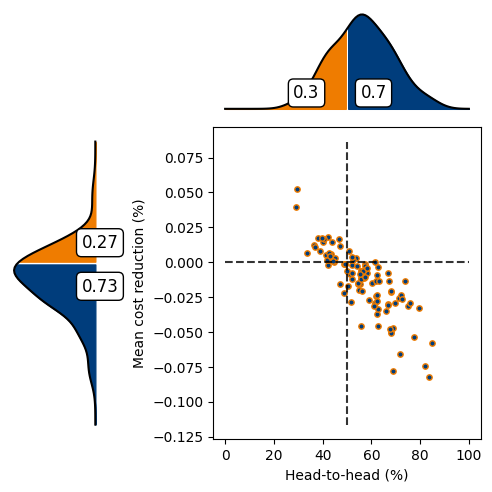

In [41]:
regret_h2h_fig.figure_plot_upleft(all_h2h_ddrols, all_mci_ddrols, figure_name = '411_ddr_ols', size = (5, 5), move = [-0.10, 0.04, 0.30, 0.55])

# Lasso vs OLS

In [37]:
all_h2h_lsools,all_mci_lsools = obtain_all_rst(iters,DataPath,"Lasso_vs_OLS.pkl")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


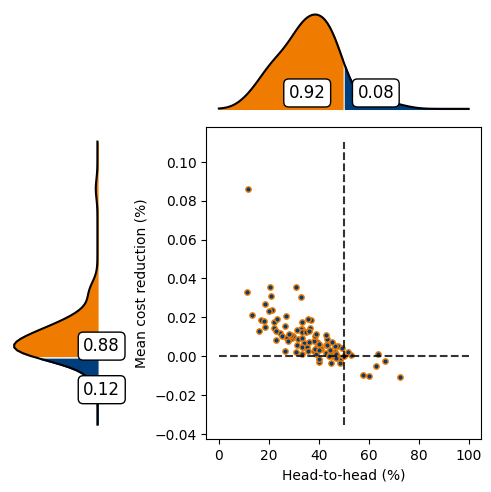

In [38]:
regret_h2h_fig.figure_plot_upleft(all_h2h_lsools, all_mci_lsools, figure_name = '411_ddr_ols', size = (5, 5), move = [-0.10, 0.04, 0.30, 0.55])

# OLS vs SPO

In [39]:
all_h2h_olsspo,all_mci_olsspo = obtain_all_rst(iters,DataPath,"Lasso_vs_OLS.pkl")